In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias.html

In [2]:
filename = 'covid19-es-and.csv'
fecha = '09/06/2020'
id_noticia = '237629'
url = 'https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias/detalle/' + id_noticia + '.html'

In [3]:
# Load
tables = pd.read_html(url, header=0, thousands='.')
assert len(tables) > 0
dfL = tables[0]

In [4]:
# Prepare
dfL['Fecha'] = fecha
# A partir del 14/05/2020 se cambia el formato del dato añadiendo en la misma columna el número de nuevos casos
for col in ['PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos',	'Curados']:
    dfL[col] = dfL[col].str.split(' ').str[0]

dfL

,Provincia,PCR Positivo,Hospitalización,UCI,Fallecimientos,Curados,Fecha
0,Almería,528,245,41,54,697,09/06/2020
1,Cádiz,1.277,587,83,161,1.196,09/06/2020
2,Córdoba,1.349,563,76,117,1.546,09/06/2020
3,Granada,2.462,1.204,133,287,2.880,09/06/2020
4,Huelva,407,222,30,48,474,09/06/2020
5,Jaén,1.468,769,91,185,1.593,09/06/2020
6,Málaga,2.822,1.494,168,287,2.993,09/06/2020
7,Sevilla,2.486,1.207,151,289,2.833,09/06/2020
8,Total,12.799,6.291,773,1.428,14.212,09/06/2020


In [5]:
data = pd.melt(dfL, id_vars=['Provincia', 'Fecha'])
data.sample(5)

,Provincia,Fecha,variable,value
10,Cádiz,09/06/2020,Hospitalización,587
22,Huelva,09/06/2020,UCI,30
41,Jaén,09/06/2020,Curados,1.593
23,Jaén,09/06/2020,UCI,91
5,Jaén,09/06/2020,PCR Positivo,1.468


In [6]:
# Save to csv
data.to_csv(filename, encoding='utf-8', header=False, mode='+a', index=False)

In [7]:
# Load full csv
dfL = pd.read_csv(filename, thousands='.', parse_dates=['Fecha'], dayfirst=True)
dfL.tail()

,Provincia,Fecha,variable,value
2560,Huelva,2020-06-09,Curados,474
2561,Jaén,2020-06-09,Curados,1593
2562,Málaga,2020-06-09,Curados,2993
2563,Sevilla,2020-06-09,Curados,2833
2564,Total,2020-06-09,Curados,14212


In [8]:
# Guardar el último día
last_fecha = dfL['Fecha'].max()

In [9]:
# Organizar en forma de tabla
df = pd.pivot_table(dfL, values='value', index=['Provincia', 'Fecha'], columns='variable')
df.sort_index(inplace=True)

In [10]:
# Variaciones con respecto al día anterior
dfV = df.groupby(level='Provincia').pct_change() * 100
dfV.tail()

Curados  Fallecimientos  Hospitalización  PCR Positivo  \
Provincia Fecha                                                                 
Total     2020-06-05  0.828970        0.070323        -0.015908      0.094096   
          2020-06-06  0.887062        0.000000         0.063644      0.180180   
          2020-06-07  0.107227        0.140548         0.031802      0.062559   
          2020-06-08  0.192802        0.000000         0.000000     -0.007815   
          2020-06-09  1.290001        0.210526         0.000000      0.031262   

                           UCI  
Provincia Fecha                 
Total     2020-06-05  0.130039  
          2020-06-06  0.389610  
          2020-06-07  0.000000  
          2020-06-08  0.000000  
          2020-06-09  0.000000

In [11]:
# Para seleccionar todas las filas de una o varias fechas hay que usar un trick ya que : no se puede usar en este caso
dfG = dfV.loc[(slice(None), [last_fecha]), :]

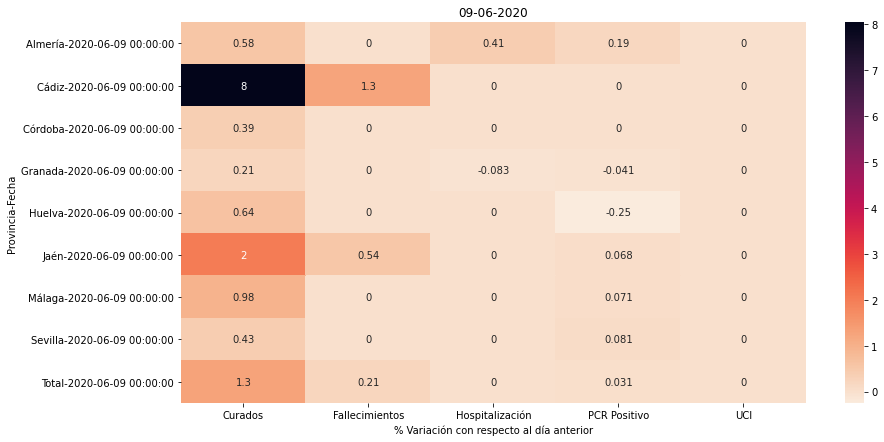

In [12]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title(last_fecha.strftime('%d-%m-%Y'))

# Invertir los colores
cmap = sns.cm.rocket_r

# Heatmap 
sns.heatmap(data=dfG, annot=True, cmap=cmap)

# Add label for horizontal axis
plt.xlabel('% Variación con respecto al día anterior')
plt.show()

In [13]:
provincia = 'Total'
dias = 15
# data = df.loc[provincia][['Hospitalización', 'Curados', 'Fallecimientos']].diff().tail(dias).copy()
data = df.loc[provincia].diff().tail(dias).copy()
titulo = 'Nuevos casos en los últimos ' + str(dias) + ' días en ' + provincia


In [14]:
print(titulo)
print(data)

Nuevos casos en los últimos 15 días en Total
variable    Curados  Fallecimientos  Hospitalización  PCR Positivo  UCI
Fecha                                                                  
2020-05-26    264.0            14.0             12.0           NaN  NaN
2020-05-27    196.0             5.0              0.0           NaN  NaN
2020-05-28    167.0             3.0              2.0           NaN  NaN
2020-05-29    201.0             0.0              4.0           NaN  NaN
2020-05-30    199.0             3.0              9.0           NaN  NaN
2020-05-31     66.0             2.0              1.0           NaN  NaN
2020-06-01     46.0            -1.0              1.0           NaN  NaN
2020-06-02    157.0             1.0              8.0          28.0  0.0
2020-06-03    120.0             0.0              6.0          16.0 -1.0
2020-06-04    106.0             3.0             10.0          16.0  0.0
2020-06-05    114.0             1.0             -1.0          12.0  1.0
2020-06-06    123.0

Nuevos casos en los últimos 15 días en Total. (Nuevos ingresos hospitalarios)


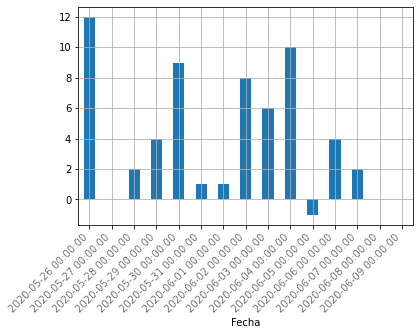

In [15]:
print(titulo + '. (Nuevos ingresos hospitalarios)')
data['Hospitalización'].plot(kind='bar', grid=True)
plt.xticks(
    rotation=45,    
    horizontalalignment='right',
    fontweight='light',
)
plt.show()

In [16]:
# Fecha de último ingreso en hospital
data = df[['Hospitalización']].diff()
data = data[data['Hospitalización'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values('dias', ascending=False)

variable,Fecha,Hospitalización,dias
Provincia,,,
Jaén,2020-06-03,1.0,6 days
Sevilla,2020-06-04,2.0,5 days
Cádiz,2020-06-05,1.0,4 days
Huelva,2020-06-06,1.0,3 days
Córdoba,2020-06-06,2.0,3 days
Total,2020-06-07,2.0,2 days
Málaga,2020-06-07,1.0,2 days
Granada,2020-06-07,1.0,2 days
Almería,2020-06-09,1.0,0 days
